In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
df_train = pd.read_csv('train.csv')
df_train

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [3]:
df_test = pd.read_csv('test.csv')
df_test

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [5]:
df_train.isnull().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [6]:
df_train['country'].value_counts()

Finland    8766
Norway     8766
Sweden     8766
Name: country, dtype: int64

In [7]:
df_train['store'].value_counts()

KaggleMart    13149
KaggleRama    13149
Name: store, dtype: int64

In [8]:
df_train['product'].value_counts()

Kaggle Mug        8766
Kaggle Hat        8766
Kaggle Sticker    8766
Name: product, dtype: int64

In [9]:
df_train['date'].value_counts()

2015-01-01    18
2017-09-09    18
2017-09-07    18
2017-09-06    18
2017-09-05    18
              ..
2016-04-30    18
2016-04-29    18
2016-04-28    18
2016-04-27    18
2018-12-31    18
Name: date, Length: 1461, dtype: int64

In [10]:
df_gdp = pd.read_csv('GDP_data_2015_to_2019_Finland_Norway_Sweden.csv', index_col='year')
df_gdp

,GDP_Finland,GDP_Norway,GDP_Sweden
year,,,
2015,234.440,385.802,505.104
2016,240.608,368.827,515.655
2017,255.017,398.394,541.019
2018,275.580,437.000,555.455
2019,268.782,405.510,533.880


In [11]:
def smape(target, predicted):
    return 100/len(target) * np.sum(2 * np.abs(predicted - target) / (np.abs(target) + np.abs(predicted)))

In [12]:
gdp_weight = dict()
gdp_shift = dict()

In [13]:
def objective(trial, comb, data):
    country, store, product = comb
    gdp_weight[comb] = trial.suggest_float(f'weight', 0.0, 5.0)
    gdp_shift[comb] = trial.suggest_float(f'shift', 0.0, 5.0)
    gdp = data.loc[(data['country'] == country) & (data['store'] == store)
                  & (data['product'] == product), 'gdp']
    num_sold = data.loc[(data['country'] == country) & (data['store'] == store)
                  & (data['product'] == product), 'num_sold']
    
    if 'Kaggle Hat' in comb:
        time = np.arange(0, np.pi*8, np.pi*8 / len(data));
        amplitude = np.sin(time)
        
    elif 'Kaggle Mug' in comb:
        time = np.arange(0, np.pi*8, np.pi*8 / len(data));
        amplitude = np.cos(time)
    
    elif 'Kaggle Sticker' in comb:
        amplitude = 1.0
    
    preds = amplitude*gdp*gdp_weight[comb] + gdp*gdp_shift[comb]
    return smape(num_sold, preds)

In [ ]:
import optuna

new_df = df_train.copy()
new_df['gdp'] = 0.0
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['year'] = new_df['date'].dt.year
for year in new_df['year'].unique():
    for country in new_df['country'].unique():
        new_df.loc[(new_df['year'] == year) & (new_df['country'] == country), 'gdp'] = \
                     df_gdp.loc[year, f'GDP_{country}']

for comb, data in new_df.set_index('date').groupby(['country', 'store', 'product']):
    
    country, store, product = comb
    
    objective_run = lambda trials: objective(trials, comb, data)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_run, n_trials=300)
    params = study.best_trial.params
    gdp_weight[comb] = params['weight']
    gdp_shift[comb] = params['shift']

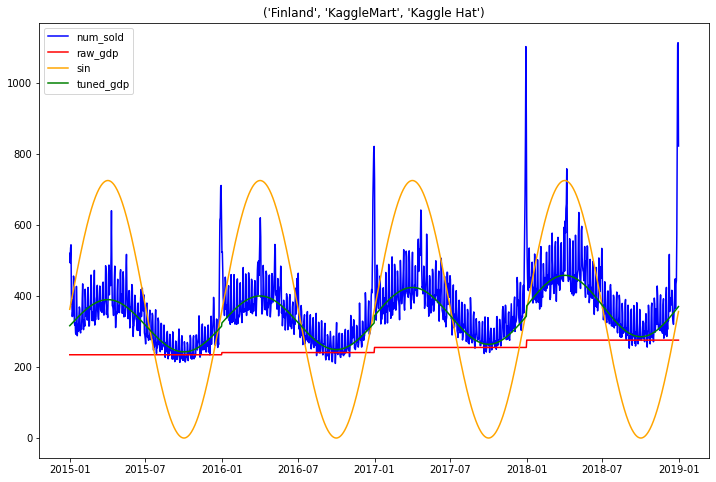

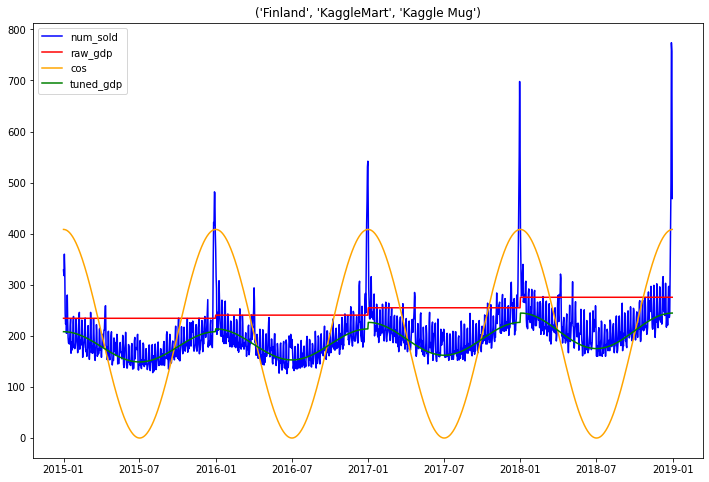

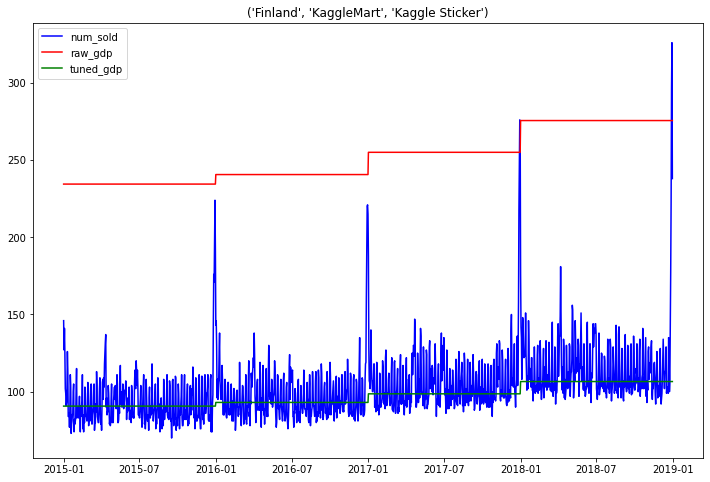

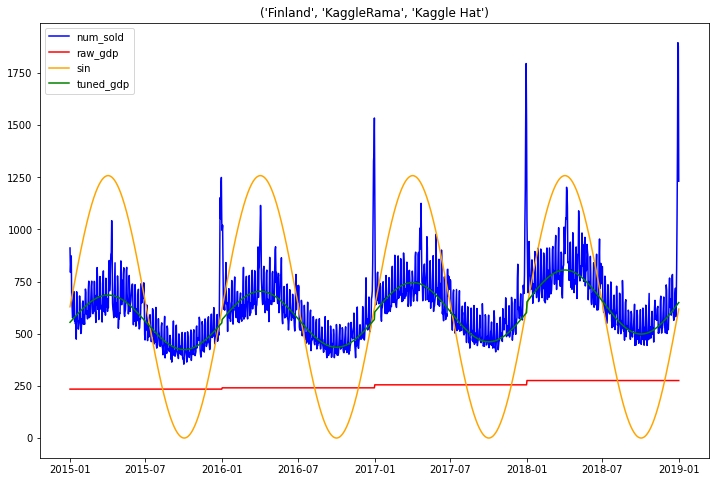

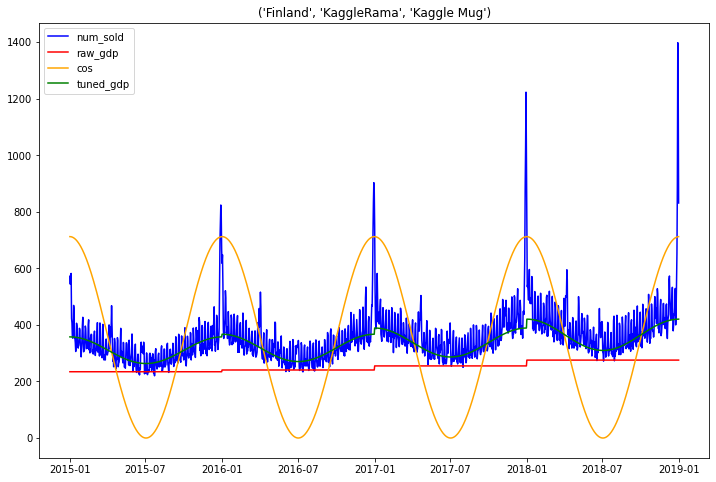

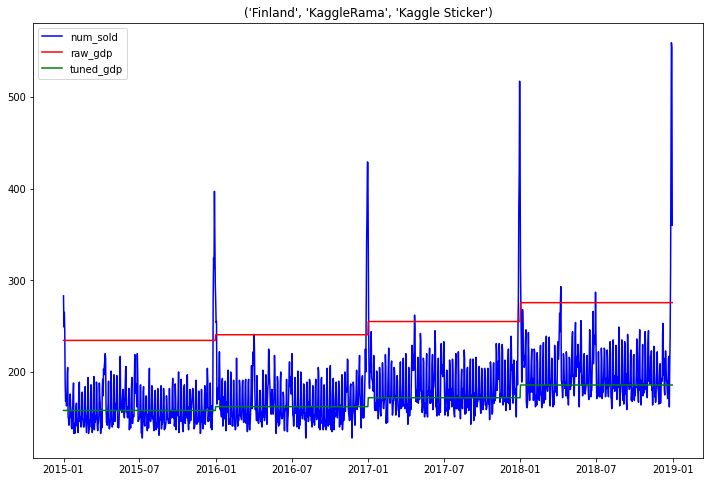

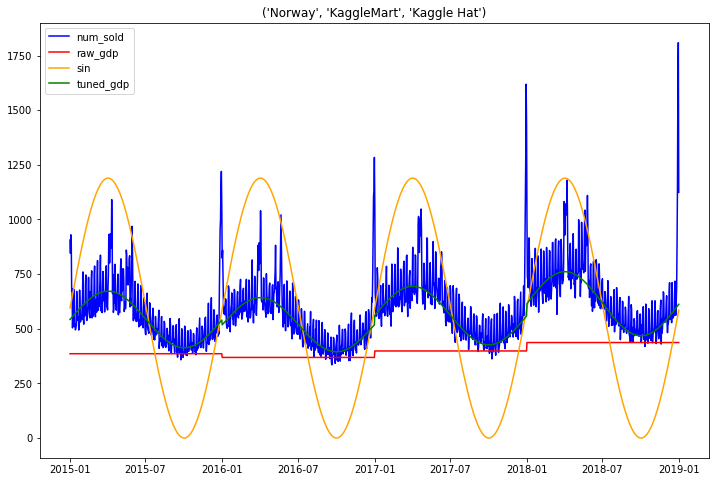

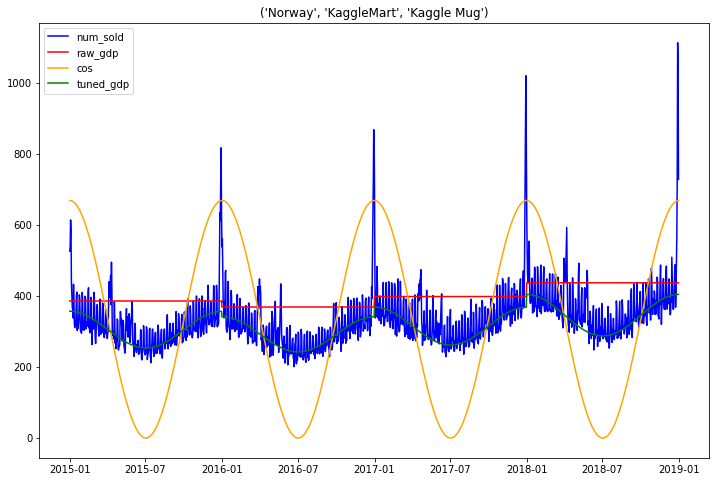

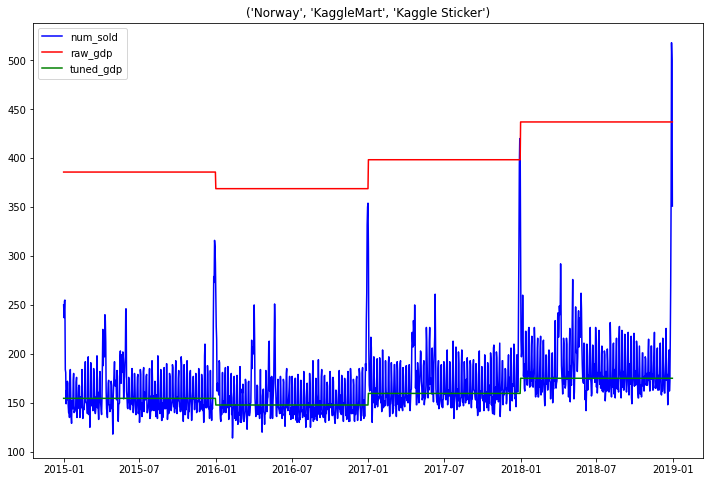

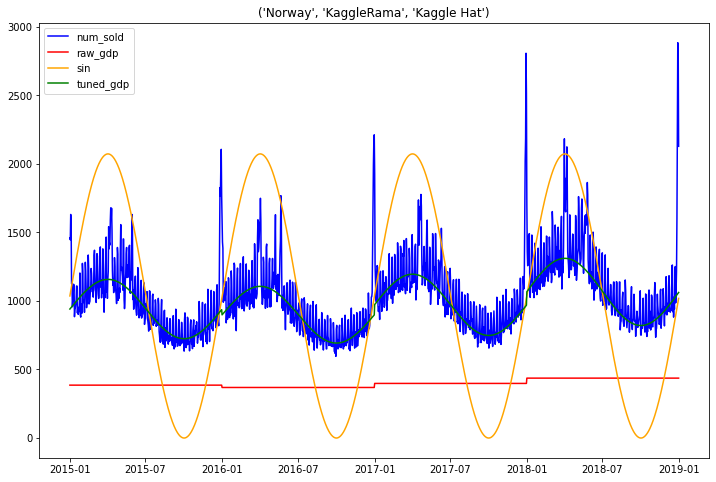

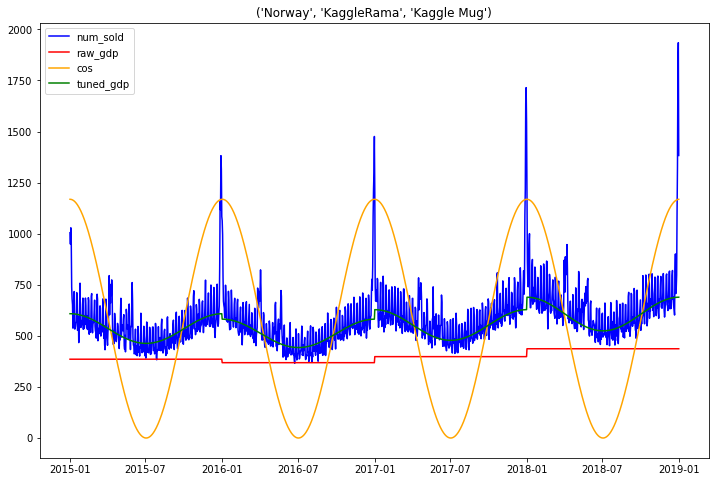

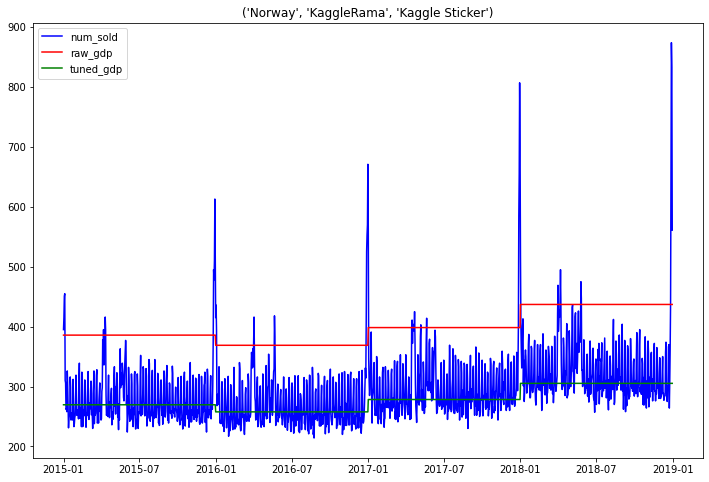

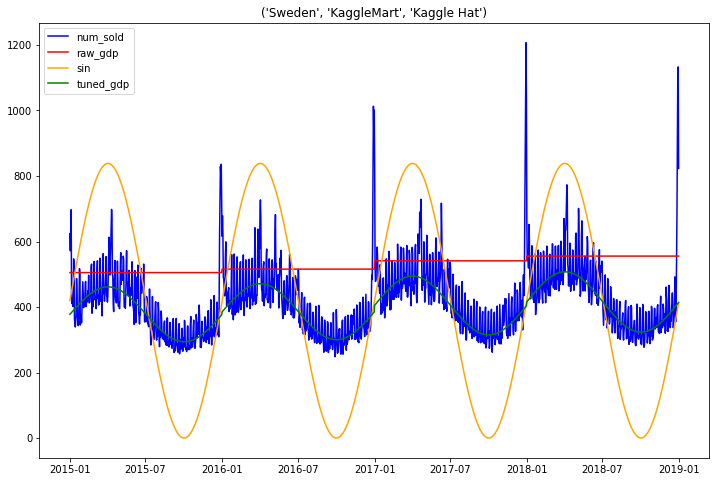

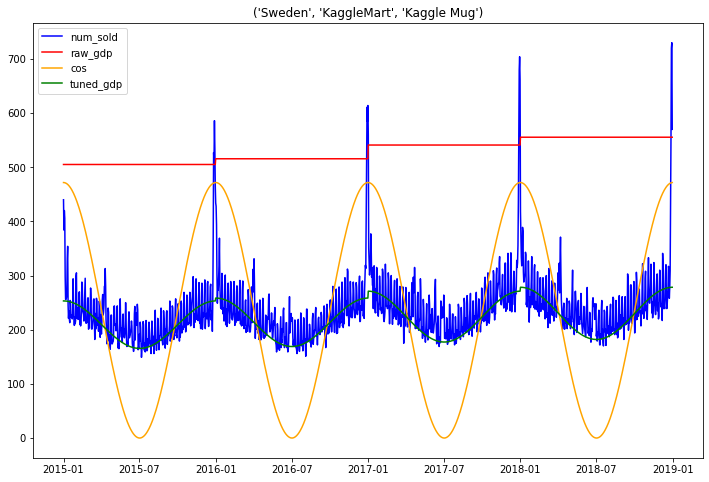

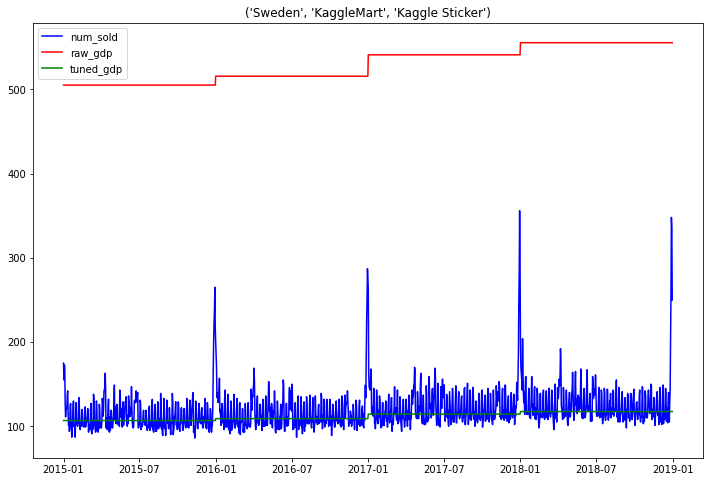

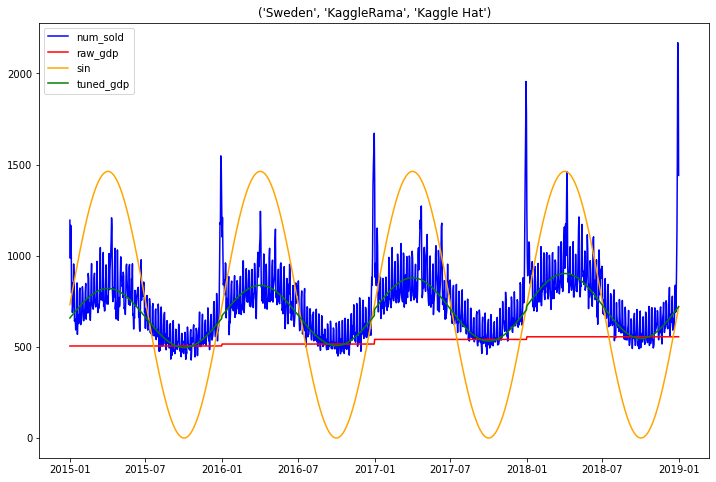

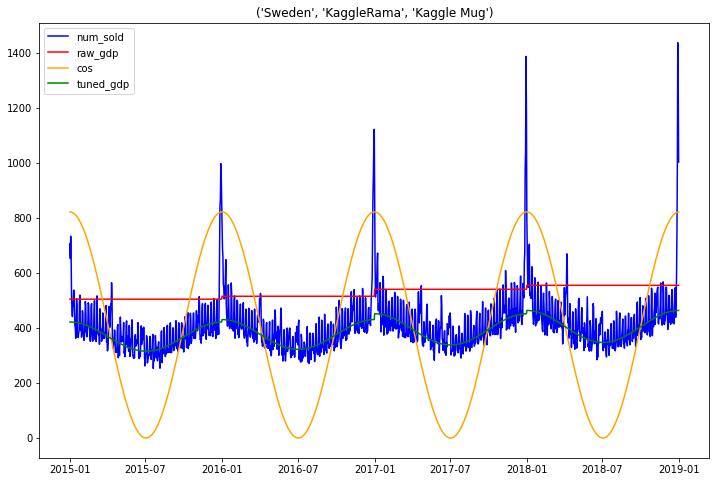

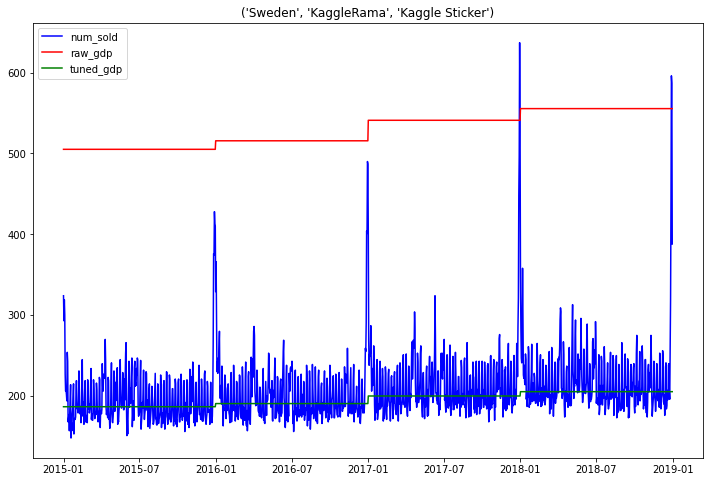

In [15]:
import matplotlib.pyplot as plt

new_df = df_train.copy()
new_df['gdp'] = 0.0
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['year'] = new_df['date'].dt.year
for year in new_df['year'].unique():
    for country in new_df['country'].unique():
        new_df.loc[(new_df['year'] == year) & (new_df['country'] == country), 'gdp'] = \
                     df_gdp.loc[year, f'GDP_{country}']

for comb, data in new_df.set_index('date').groupby(['country', 'store', 'product']):
    fig = plt.subplots(figsize=(12, 8))
    plt.plot(data['num_sold'], color='blue', label='num_sold')
    
    plt.plot(data.index, data['gdp'], color='red', label='raw_gdp')
    
    country, store, product = comb
    
    if 'Kaggle Hat' in comb:
        time = np.arange(0, np.pi*8, np.pi*8 / len(data));
        amplitude = np.sin(time)
        plt.plot(data.index, (amplitude*data['num_sold'].mean()) + data['num_sold'].mean(), color='orange', label='sin')
        
        data.loc[(data['country'] == country) & (data['store'] == store) & \
                (data['product'] == product), 'gdp'] = \
                ((amplitude*data['gdp'])*gdp_weight[comb]) + data['gdp']*gdp_shift[comb]
        
    elif 'Kaggle Mug' in comb:
        time = np.arange(0, np.pi*8, np.pi*8 / len(data));
        amplitude = np.cos(time)
        plt.plot(data.index, (amplitude*data['num_sold'].mean()) + data['num_sold'].mean(), color='orange', label='cos')
        
        data.loc[(data['country'] == country) & (data['store'] == store) & \
                (data['product'] == product), 'gdp'] = \
                ((amplitude*data['gdp'])*gdp_weight[comb]) + data['gdp']*gdp_shift[comb]
    
    elif 'Kaggle Sticker' in comb:
        data.loc[(data['country'] == country) & (data['store'] == store) & \
                (data['product'] == product), 'gdp'] = data['gdp']*gdp_weight[comb] + data['gdp']*gdp_shift[comb]
    
    plt.plot(data.index, data['gdp'], color='green', label='tuned_gdp')
    plt.title(comb)
    plt.legend(loc='best')
    plt.show()

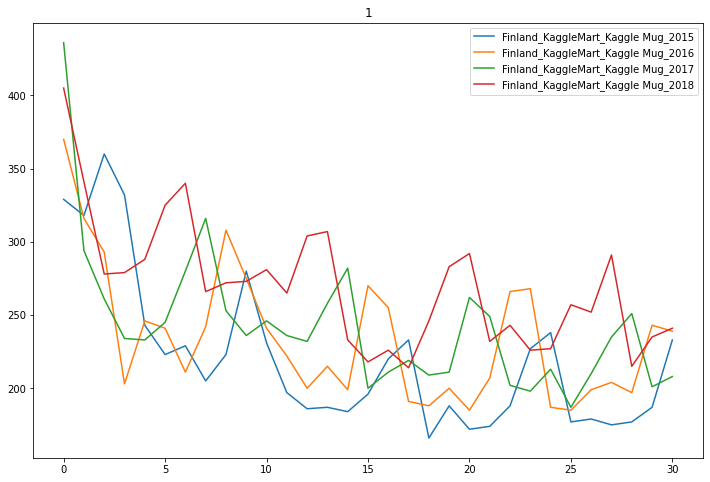

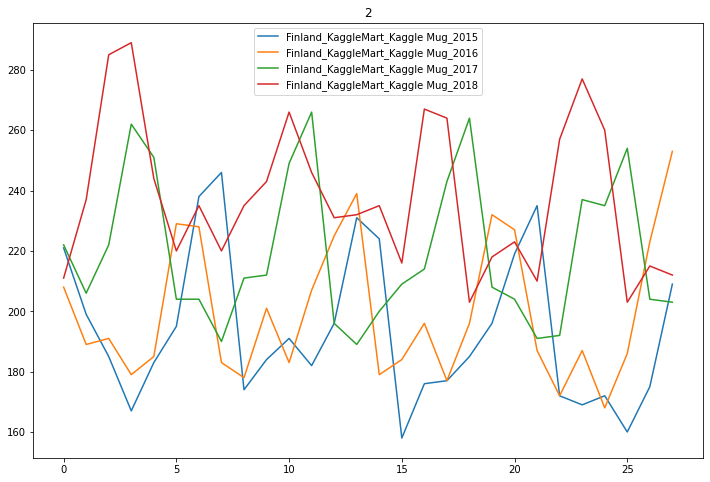

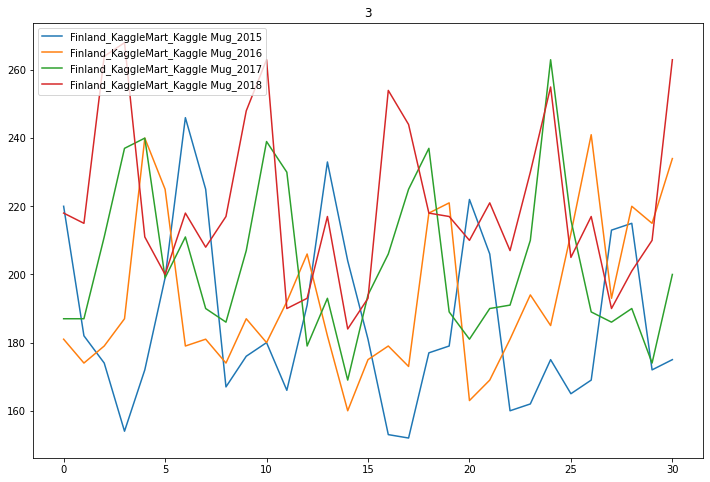

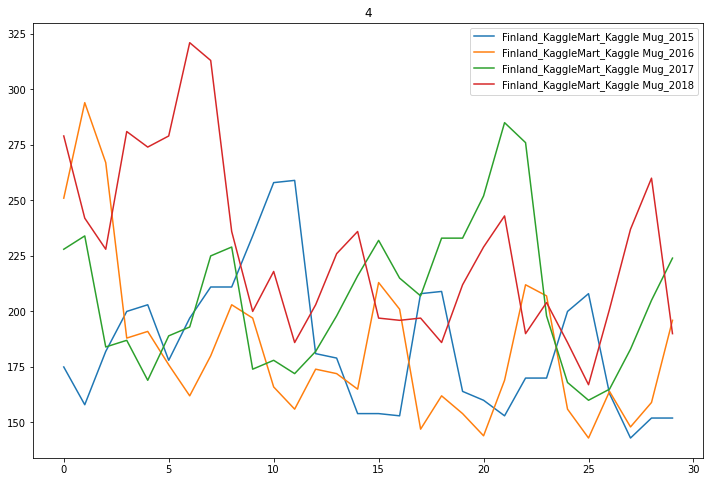

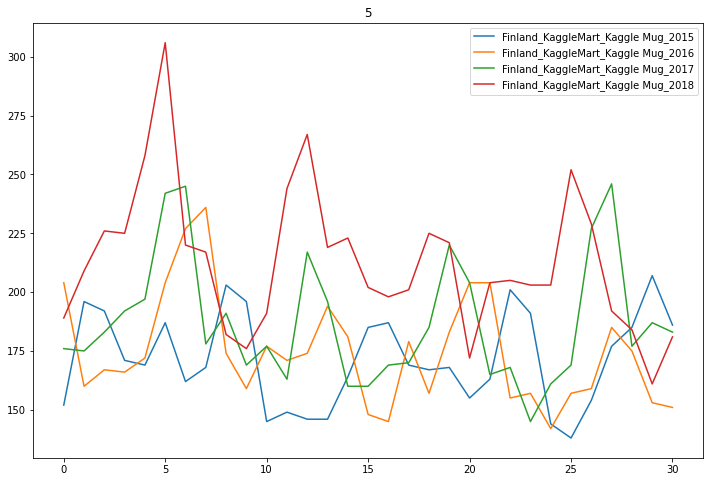

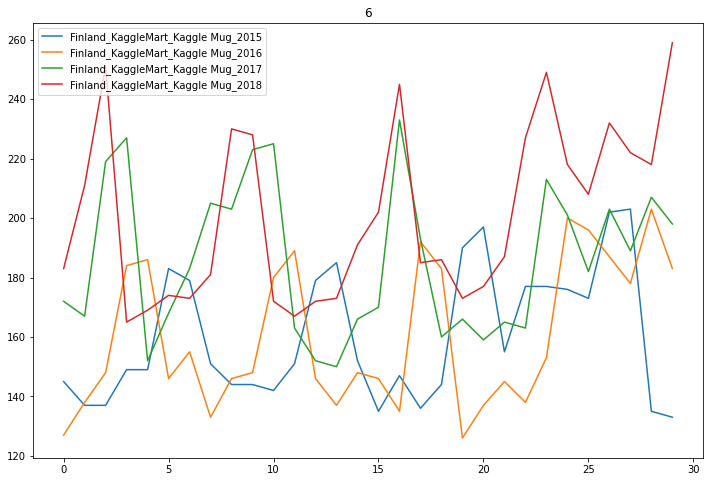

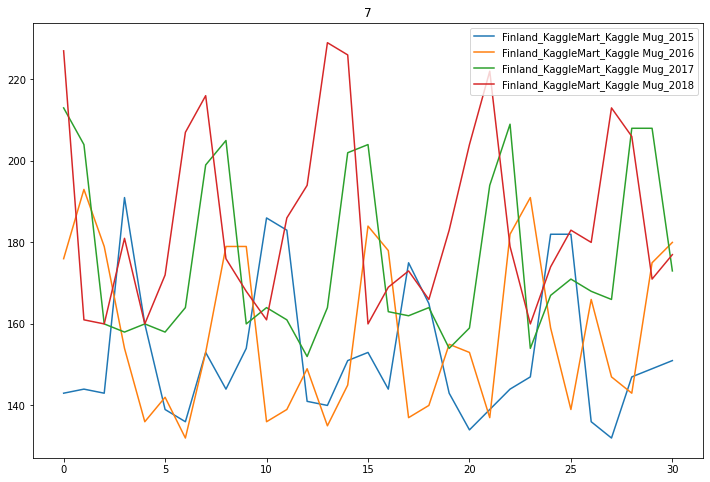

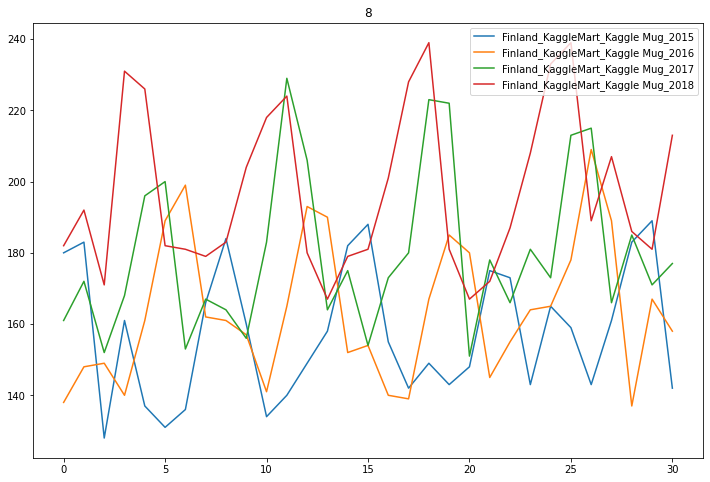

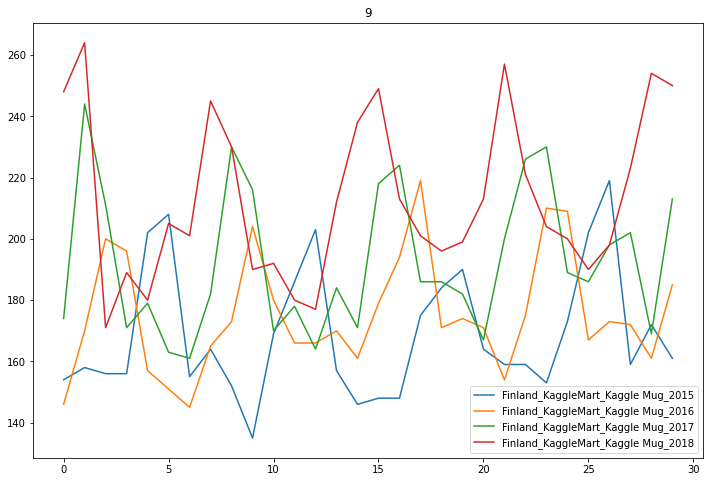

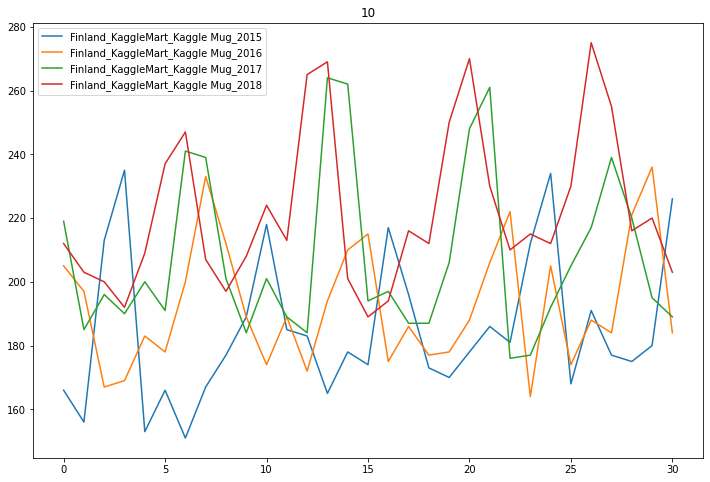

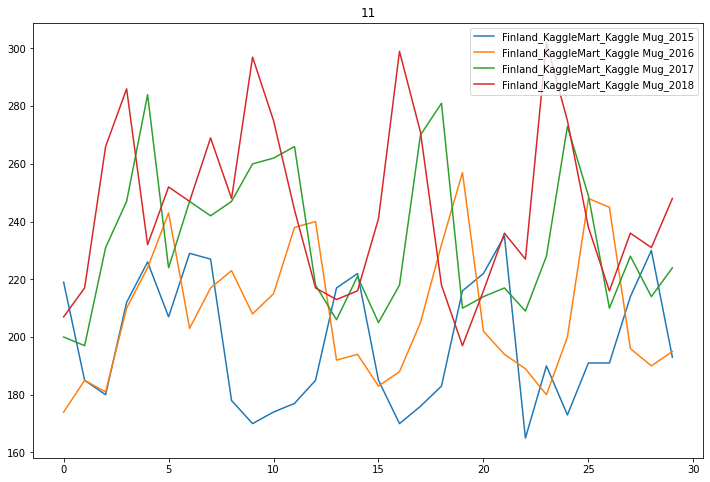

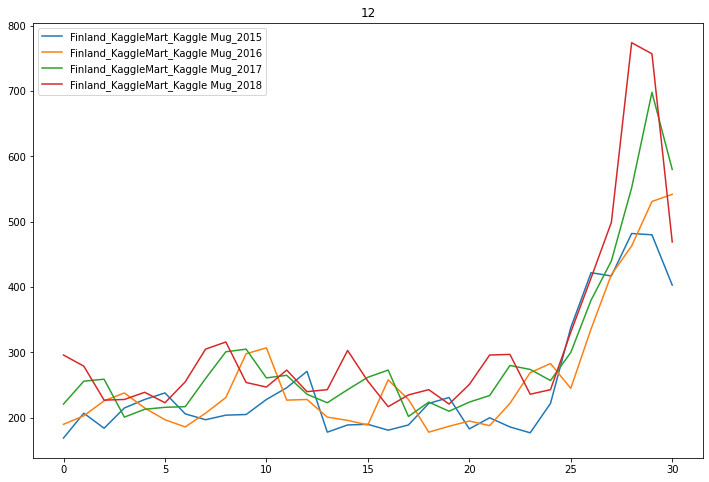

In [17]:
new_df = df_train.copy()
new_df['date'] = pd.to_datetime(new_df['date'])
new_df['month'] = new_df['date'].dt.month
new_df['year'] = new_df['date'].dt.year
new_df = new_df.set_index('date')

for month in new_df['month'].unique():
    fig = plt.subplots(figsize=(12, 8))
    for country in new_df['country'].unique():
        for store in new_df['store'].unique():
            for product in new_df['product'].unique():
                for year in new_df['year'].unique():
                    plot_df = pd.DataFrame()
                    plot_df = new_df.loc[(new_df['year'] == year) & \
                             (new_df['month'] == month) & \
                             (new_df['country'] == country) & \
                             (new_df['store'] == store) & \
                             (new_df['product'] == product), \
                             'num_sold'].copy()
                    if year == 2016 and month == 2:
                        plot_df = plot_df[:'2016-02-28']
                    plot_df.index = range(len(plot_df))
                    plt.plot(plot_df, label=f'{country}_{store}_{product}_{year}')
                break
            break
        break
    plt.legend(loc='best')
    plt.title(f'{month}')
    plt.show()

In [18]:
def prepare_data(data):
    
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day
    data['day_of_week'] = data['date'].dt.day_of_week
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofyear'] = data['date'].dt.dayofyear
    data.loc[(data['year'] != 2016) & (data['month'] >= 3), 'dayofyear'] += 1
    
    data['gdp'] = 0.0
    for year in data['year'].unique():
        for country in data['country'].unique():
            data.loc[(data['year'] == year) & (data['country'] == country), 'gdp'] = \
                         df_gdp.loc[year, f'GDP_{country}']
    
    for comb, df_group in data.groupby(['country', 'store', 'product']):
        country, store, product = comb
    
        if 'Kaggle Hat' in comb:
            time = np.arange(0, np.pi*8, np.pi*8 / len(df_group));
            amplitude = np.sin(time)

            data.loc[(data['country'] == country) & (data['store'] == store) & \
                    (data['product'] == product), 'gdp'] = \
                    ((amplitude*df_group['gdp'])*gdp_weight[comb]) + df_group['gdp']*gdp_shift[comb]

        elif 'Kaggle Mug' in comb:
            time = np.arange(0, np.pi*8, np.pi*8 / len(df_group));
            amplitude = np.cos(time)

            data.loc[(data['country'] == country) & (data['store'] == store) & \
                    (data['product'] == product), 'gdp'] = \
                    ((amplitude*df_group['gdp'])*gdp_weight[comb]) + df_group['gdp']*gdp_shift[comb]

        elif 'Kaggle Sticker' in comb:
            data.loc[(data['country'] == country) & (data['store'] == store) & \
                    (data['product'] == product), 'gdp'] = df_group['gdp']*gdp_weight[comb] + df_group['gdp']*gdp_shift[comb]

    data['country'] = data['country'].factorize()[0]
    data['store'] = data['store'].factorize()[0]
    data['product'] = data['product'].factorize()[0]

    #data = data.drop(['row_id', 'date'], axis=1)

    return data

In [19]:
import dateutil.easter as easter

# I took this code from kaggle
def dates_shift(df):
    new_df = df.copy()
    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df['days_from_easter'] = (df.date - easter_date).dt.days.clip(-3, 59)
    new_df.loc[new_df['days_from_easter'].isin(range(12, 39)), 'days_from_easter'] = 12 # reduce overfitting
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)
    
    # First Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)
    
    new_df = new_df.drop(['row_id', 'date'], axis=1)
    
    return new_df

In [20]:
submission = df_test[['row_id']]
df_train = prepare_data(df_train)
df_train = dates_shift(df_train)
df_test = prepare_data(df_test)
df_test = dates_shift(df_test)

In [21]:
df_train

,country,store,product,num_sold,day,day_of_week,month,year,dayofyear,gdp,days_from_easter,days_from_wed_jun,days_from_sun_nov
0,0,0,0,329,1,3,1,2015,1,208.159790,-3,-5,-1
1,0,0,1,520,1,3,1,2015,1,316.144506,-3,-5,-1
2,0,0,2,146,1,3,1,2015,1,90.670486,-3,-5,-1
3,0,1,0,572,1,3,1,2015,1,357.648012,-3,-5,-1
4,0,1,1,911,1,3,1,2015,1,554.624191,-3,-5,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,2,0,1,823,31,0,12,2018,366,413.808232,59,5,9
26294,2,0,2,250,31,0,12,2018,366,117.446873,59,5,9
26295,2,1,0,1004,31,0,12,2018,366,464.175581,59,5,9
26296,2,1,1,1441,31,0,12,2018,366,721.273196,59,5,9


In [22]:
df_test

,country,store,product,day,day_of_week,month,year,dayofyear,gdp,days_from_easter,days_from_wed_jun,days_from_sun_nov
0,0,0,0,1,1,1,2019,1,238.652127,-3,-5,-1
1,0,0,1,1,1,1,2019,1,362.455011,-3,-5,-1
2,0,0,2,1,1,1,2019,1,103.952374,-3,-5,-1
3,0,1,0,1,1,1,2019,1,410.038168,-3,-5,-1
4,0,1,1,1,1,1,2019,1,635.868449,-3,-5,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
6565,2,0,1,31,1,12,2019,366,393.168486,59,5,9
6566,2,0,2,31,1,12,2019,366,112.884998,59,5,9
6567,2,1,0,31,1,12,2019,366,446.021509,59,5,9
6568,2,1,1,31,1,12,2019,366,684.410326,59,5,9


In [23]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

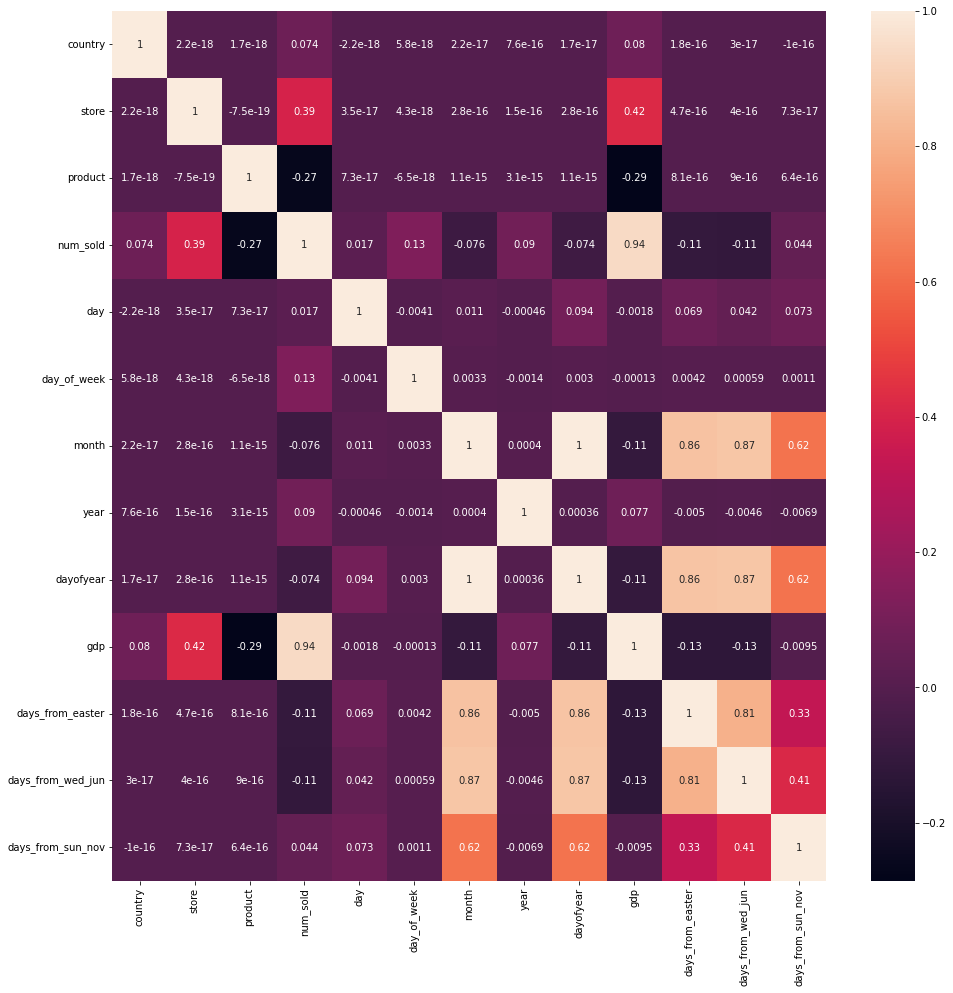

In [24]:
ax, fig = plt.subplots(figsize=(16, 16))
sns.heatmap(df_train.corr(), annot=True)

In [25]:
def lgb_run(data):
    models = []
    full_preds = np.zeros(len(data))
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(data.drop('num_sold', axis=1), data['num_sold'])):
        x_train, y_train = data.loc[trn_ind].drop('num_sold', axis=1), data.loc[trn_ind, 'num_sold']
        x_val, y_val = data.loc[val_ind].drop('num_sold', axis=1), data.loc[val_ind, 'num_sold']

        model = LGBMRegressor()
        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        full_preds[y_val.index] = predictions
        models.append(model)
    print(f'MAPE: {mean_absolute_percentage_error(data["num_sold"], full_preds)}')
    print(f'SMAPE: {smape(data["num_sold"], full_preds)}')
    ax = lgb.plot_importance(models[-1], max_num_features=40, figsize=(15,15))
    plt.show()
    return models

MAPE: 0.04522581916888634
SMAPE: 4.502711123630534


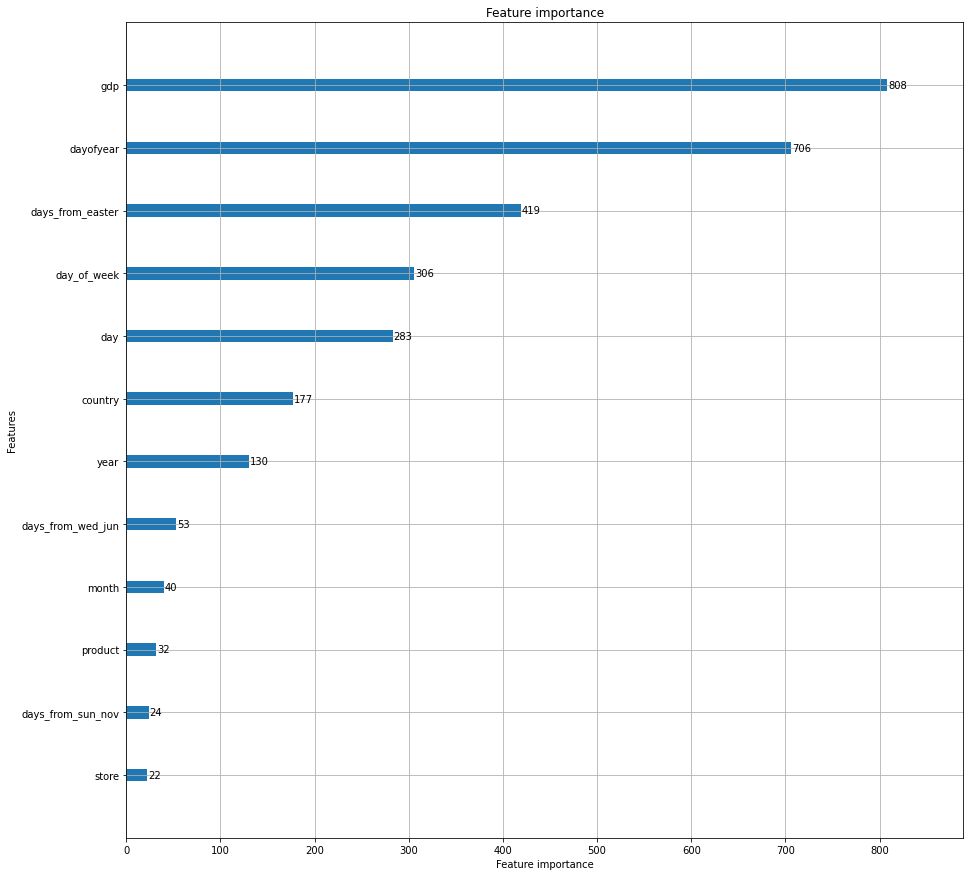

In [26]:
models = lgb_run(df_train)

In [27]:
test_preds = np.zeros(len(df_test))
for model in models:
    test_preds = test_preds + model.predict(df_test)
test_preds /= len(models)
test_preds

array([ 377.79197615,  567.30067491,  172.3072795 , ...,  810.00743177,
       1419.19954278,  404.37200293])

In [28]:
# This gave me 13.17092 score
submission['num_sold'] = test_preds
submission.to_csv('submission.csv', index=False)

/tmp/ipykernel_17389/3349033098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['num_sold'] = test_preds


In [29]:
preds = np.zeros(len(df_train))
for model in models:
    preds += model.predict(df_train.drop('num_sold', axis=1))
preds /= len(models)
preds

array([ 333.51020371,  483.96819691,  145.56173548, ...,  902.8656133 ,
       1583.80090992,  409.85241287])

In [30]:
smape(df_train['num_sold'], preds)

4.261724048622578